In [65]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import pykitti
from scipy.spatial.transform import Rotation as R
import sys
sys.path.append('../')
from vo_funcs import VisualOdometry
from tqdm import tqdm
DATA_DIR = '../data' 
degree = 30
R_oxts_cam = np.array(R.from_euler('z', degree, degrees=True).as_matrix())
%matplotlib inline

In [2]:
def load_data(date, drive):
    data = pykitti.raw(DATA_DIR, date, drive)
    return data

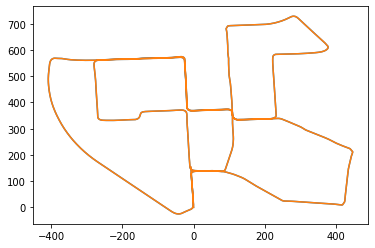

In [66]:
data = load_data('2011_10_03', '0027')
# data = load_data('2011_09_26', '0001')
x, y, z = [], [], []
x_imu = []
y_imu = []
dt = 0.1
R, t_start = pykitti.utils.pose_from_oxts_packet(data.oxts[0].packet, scale=1)
# t_start = R_oxts_cam @ t_start
for i in range(len(data.timestamps)):
    R, t = pykitti.utils.pose_from_oxts_packet(data.oxts[i].packet, scale=1)
    t -= t_start
    t = R_oxts_cam @ t
    x_vel = data.oxts[i].packet.ve
    y_vel = data.oxts[i].packet.vn
    x_vel, y_vel, z_vel = R_oxts_cam @ np.array([x_vel, y_vel, 0])
    x_acc = data.oxts[i].packet.ax
    y_acc = data.oxts[i].packet.ay
    # print(t)
    if len(x_imu) == 0:
        x_imu.append(0)
        y_imu.append(0)
    else:
        x_imu.append(t[0]+x_vel*dt) #+0.5*x_acc*dt**2)
        y_imu.append(t[1]+y_vel*dt) #+0.5*y_acc*dt**2)
        # x_imu.append(x_imu[i-1]+0.5*x_acc*dt**2)
        # y_imu.append(y_imu[i-1]+0.5*y_acc*dt**2)
    x.append(t[0])
    y.append(t[1])
    z.append(t[2])
# plt.axes(projection='3d')
# plt.plot(x[:200], y[:200])
# plt.plot(x_imu[:200], y_imu[:200])
plt.plot(x, y)
plt.plot(x_imu, y_imu)
plt.show()

In [4]:
print(len(data.oxts))
print(len(data.cam0_files))

4544
4544


In [5]:
print([ i.packet.vn for i in data.oxts[:10]])

[5.91181523139241, 5.99993947855496, 6.0880637257175, 6.17618797288005, 6.2643122200426, 6.35243646720515, 6.4405607143677, 6.52868496153025, 6.6168092086928, 6.70493345585535]


In [6]:
print(np.array(x[1:10])-np.array(x[:9]))

[0.58423359 0.58423359 0.58423359 0.58423359 0.58423359 0.58423359
 0.58423359 0.58423359 0.58423359]


In [7]:
print([ i.packet.au*0.1 for i in data.oxts[:10]])

[1.3026404235734301, 1.2818228622644852, 1.2610053009555402, 1.2401877396465952, 1.21937017833765, 1.198552617028705, 1.1777350557197601, 1.1569174944108152, 1.13609993310187, 1.115282371792925]


In [59]:
class SensorFusion():
    def __init__(self, start_state, data: pykitti.raw, cutout_region=list(range(10,20))):
        self.data = data
        _, self.t_start = pykitti.utils.pose_from_oxts_packet(data.oxts[0].packet, scale=1)
        self.state = start_state
        self.pred_state = np.zeros(len(start_state))
        self.cutout_region = cutout_region
        self.vo = VisualOdometry(data)
        self.pose_est = [self.state]
        self.pose_gt = [self.getGPS(0)]
        self.pose_vo = [[0,0,0]]

    def getOXTSMeasurement(self, index, H):
        t = self.getGPS(index)

        x, y, z = t[:3]
        x_vel = data.oxts[i].packet.ve
        y_vel = data.oxts[i].packet.vn
        x_vel, y_vel, z_vel = R_oxts_cam @ np.array([x_vel, y_vel, 0])
        
        pos_uncertainty = data.oxts[index].packet.pos_accuracy
        vel_uncertainty = data.oxts[index].packet.vel_accuracy

        R = np.array([
            [pos_uncertainty**2, 0],
            [0, vel_uncertainty**2]
        ])
        if index in self.cutout_region:
            pos_sigma = 100 # meters
            R = np.array([ 
                [pos_sigma**2, 0],
                [0, vel_uncertainty**2]
            ])
            return H @ np.array([x+ np.random.normal(0, pos_sigma), x_vel]), R
        return H @ np.array([x, x_vel]), R

    def getGPS(self, index):
        R, t = pykitti.utils.pose_from_oxts_packet(self.data.oxts[index].packet, scale=1)
        t -= self.t_start
        t = R_oxts_cam @ t
        return t

    def predict(self, A, B, u, P, Q):
        predicted_X = A @ self.state + B @ u
        predicted_P = A @ P @ A.T + Q
        return predicted_X, predicted_P

    def calc_gain(self, P, H, R):
        numerator = P@H.T
        denominator = H@P@H.T + R
        K = numerator/denominator
        # print(K)
        K[0,1] = 0
        K[1,0] = 0
        return K

    def update(self, K, z, H, P):
        # print(K)
        updated_X = self.pred_state + K @ (z - H@self.pred_state)
        n = len(K@H)
        updated_P = (np.eye(n)-K@H)@P
        return updated_X, updated_P
        
    def run(self, n_iter, A, B, P, Q, H):
        dt = 0.1
        for i, gt_pose in enumerate(tqdm(self.vo.gt_poses[:n_iter], unit="poses")):
            # Get VO control input velocity
            if i < 1:
                cur_pose = self.vo.gt_poses[0]
                delta_x = cur_pose[0, 3]
            else:
                transf = self.vo.get_pose(i)
                old_pose = np.copy(cur_pose)
                cur_pose = np.matmul(cur_pose, transf)
                self.pose_vo.append(list(R_cam_oxts @ cur_pose[:3,3]))
                # print(cur_pose)
                delta_x, delta_y, delta_z = (cur_pose[:3, 3] - (old_pose[:3, 3]))
            x_vo_velocity = delta_x/dt
            # print("X_vel", x_vo_velocity)
            # print(x_vo_velocity, self.data.oxts[i].packet.vf, self.data.oxts[i].packet.vl)
            u = np.array([ 
                0,
                x_vo_velocity #+ 0.2*self.data.oxts[i].packet.vn
            ])
            # print("Iteration", i)
            #
            self.pred_state, predicted_P = self.predict(A, B, u, P, Q)
            z, R = self.getOXTSMeasurement(i, H)
            K = self.calc_gain(predicted_P, H, R)

            # print("z:", z, "predicted_X", self.pred_state)

            self.state, P = self.update(K, z, H, predicted_P)

            # print("Update_x:", self.state, "GT:", self.getGPS(i))
            
            self.pose_est.append(self.state)
            self.pose_gt.append(self.getGPS(i))
        self.pose_est = np.array(self.pose_est)
        self.pose_gt = np.array(self.pose_gt)
        self.pose_vo = np.array(self.pose_vo)
    def plot_res(self):
        plt.plot(self.pose_est[:,0], label="KF Estimates")
        plt.plot(self.pose_gt[:,0], label="GT")
        plt.plot(self.pose_vo[:,0], label="VO")
        plt.legend()
        plt.show()
    def get_metrics(self):
        avg_error = np.mean(self.pose_est[:,0]-self.pose_gt[:,0])
        print(f"Average Error: {avg_error}")
        avg_cutout_error = np.sum(np.array([x[0] for x in self.pose_est[self.cutout_region]]) - np.array([x[0] for x in self.pose_gt[self.cutout_region]]))/len(self.cutout_region)
        print(f"Average Error in cutout: {avg_cutout_error}")
        return avg_error
    def simulateCutout(startInd, endInd):
        pass

In [60]:
dt = 0.1
A = np.array([
    [1, 0],
    [0, 0]
])
B = np.array([ 
    [0,dt],
    [0,0]
])
P = np.array([
    [10, 0],
    [0, 10]
])
Q = np.array([
    [1, 0],
    [0, 1]
])
H = np.array([
    [1, 0],
    [0, 1]
])

In [61]:
# data = load_data('2011_10_03', '0027')
data = load_data('2011_09_26', '0001')

start_vec = np.array([0, 0])
positions = []
gt_positions = []
kf = SensorFusion(start_vec, data)
n_iter = 20
kf.run(n_iter, A, B, P, Q, H)

  0%|          | 0/20 [00:00<?, ?poses/s]C:\Users\Bhargav\AppData\Local\Temp\ipykernel_24876\833512770.py:51: RuntimeWarning: invalid value encountered in true_divide
  K = numerator/denominator
100%|██████████| 20/20 [00:09<00:00,  2.22poses/s]


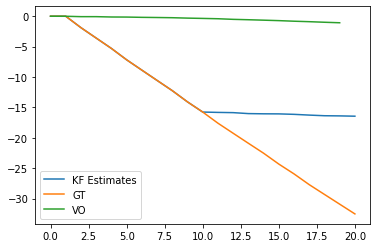

In [62]:
kf.plot_res()

In [ ]:
kf.get_metrics()

Average Error: 0.6665670017232448


TypeError: list indices must be integers or slices, not list

In [53]:
kf.pose_vo

array([array([0, 0]),
       list([0.00273652462875789, 0.05302198854123126, 1.424369016103062]),
       list([0.06176533134522323, 0.119986086392283, 2.8328604949216034]),
       list([0.033399543100627024, 0.15838722994283197, 4.185491802318585]),
       list([0.017731550993456663, 0.19831631449592585, 5.532893941075817]),
       list([-0.011147808869152814, 0.2558527719719878, 6.879123552697051]),
       list([-0.0629730785928743, 0.28458347854841703, 8.179501145884378]),
       list([-0.10927877190487532, 0.3360442736055096, 9.469396874342316]),
       list([-0.15177383593797358, 0.3801854782198642, 10.784295528183307]),
       list([-0.16463016846740383, 0.43645500975144225, 12.116317029656273]),
       list([-0.19154327857060507, 0.48067408798334166, 13.41981675550872]),
       list([-0.2492621219013386, 0.5345618856158396, 14.725926079508836]),
       list([-0.2726884110113107, 0.5867146488133748, 16.061703246728893]),
       list([-0.30763462095490174, 0.6374188542069955, 17.31